# Problem Statement: Classifying Pokemon Types

* **Vanilla version:** We want to construct a binary classifier on the feature `"type1"`, and we'll restrict ourselves to Pokemon of type `"water"` or `"normal"`. To do that, we can only use electric type moves (since Pikachu is the only Pokemon in our party), thus the only feature of the type `"against_*"` that can be considered is `"against_electric"`. Moreover, all of the features `["type2", "abilities", "classification"]` are unknown to us.

* **Off-road version:** The code below can be modified to do multiclass classification, considering both columns `["type1", "type2"]` or just one of them (this can be modified by altering the variable `TARGETS`). The considered types will be given by the variable `RESTRICTION`. Moreover, the Pokemon types in your party can be altered via the variable `SUPPORT_TYPES`.

# Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    RandomizedSearchCV,
)
from collections import Counter

# Testing
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Utils
from sklearn.utils.multiclass import type_of_target
import pprint

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Random State

We set a random state constant to be used throughout the notebook for better reproducibility.

In [43]:
RANDOM_STATE = 529

# Data Pre-Processing Stage

We want to remove from our dataset all informations that should not be available to us, those are: `"type2"`, `"abilities"`, and every `"against_" + type` where `type` isn't `"electric"`. We can achieve this by dropping all columns matching the regular expression `"type2|classification|abilities|against_(?!electric)"` (in fact, there is a typo in the database, and "classification" is written as "classfication"). It should also be noted that the columns `["pokedex_number", "name", "japanese_name"]` columns are irrelevant for our classification problem, so  we'll also drop it. One may think that `"generation"` should also be dropped but it is known that different generations have distinct typing distributions so we'll stick to it.

In a second thought, the `"name"` column may be an interesting feature to exploit due to the fact that pokemons tend to maintain a suffix or prefix throughout the whole line of evolution. This however would require an encoder that preserves string morphology in order to maintain the similarities between the pokemon names. For the time being I do not know of a technique which can deal with this.

In [44]:
df = pd.read_csv("datasets/pokemon/pokemon.csv")

Lets take a look at what we have in our hands by looking at the first few rows of our dataframe.

In [45]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


### The Darmanitan and Minior Case

Upon inspection, the pokemon named Minior (row 773) has a catch rate (column 5) that is described as `"30 (Meteorite)255 (Core)"` so I decided to use the core catch rate 255 in order to be execute our substitution strategy for missing values correctly.

In [46]:
print(df.loc[773, "capture_rate"])
df.loc[773, "capture_rate"] = 255

30 (Meteorite)255 (Core)


Another surprise is the fact that the pokemon named Darmanitan (row 554) has a wrong double typing of `("fire", "fire")`. So we'll want to reset this value of `"type2"`:

In [47]:
print(f"{df.loc[554, 'type1'], df.loc[554, 'type2']}")
df.loc[554, "type2"] = "nan"

('fire', 'fire')


## Renaming Columns

The dataset has a few inconsistencies with its naming conventions, for instance, the `"fighting"` type has a corresponding `"against_fight"` instead of `"against_fighting"` as one would assume. Moreover, there is a typo in the classification feature, which is named `"classfication"`. We thus rename such columns:

In [48]:
df.rename(columns={"against_fight": "against_fighting", "classfication": "classification"}, inplace=True)

## Filter Unknown Pokemon Features

The constant `SUPPORT_TYPES` should contain all Pokemon types we'll use in the classification of new Pokemon, that is, the types of our already acquired Pokemon. We'll assume (wrongly) that a Pokemon of a given type can only learn and use attacks of its corresponding type. Hence, we shall only consider the features `"against_" + type_` for `type in SUPPORT_TYPES` (we shall assume that only our Pokemon will deal damage and won't be damaged throughout the exploration, thus we can't use its typing weaknessess).

We can also disregard several irrelevant features for the classification of Pokemons, for instance we'll disregard `["pokemon_number", "name", "japanese_name"]`.
In our current setting, we wish to do classification only on the column `"type1"`, so we should also ignore the `"type2"` feature. Since the Pokemons we'll encounter are new to us, we won't know both the `"classification"` and `"abilities"` features.

In [49]:
# Set containing the columns corresponding to the typing information of Pokemon.
TYPE_COLS = { "type1", "type2" }

We list all columns that should be considered as targets in the classification problem.
 
* **NOTE:** If you want to consider both columns, consider changing `TARGET` to `["type1", "type2"]`. By default we'll consider only `"type1"`.

In [50]:
TARGETS = ["type1"]

In [51]:
# String that will be used to match via regex the columns that should be dropped.
unknown_features = "classfication|abilities|pokedex_number|japanese_name|name"

# Remove type columns that shouldn't be considered.
for col in TYPE_COLS - set(TARGETS):
    unknown_features += f"|{col}"

Now we collect all available types in the columns corresponding to the targets to be classified. To do that, we create a set with all types from `"type1"` (which are guaranteed to exist since every Pokemon has to have a first type), and include in this set the types appearing in the column `"type2"` (note however that not every Pokemon is double typed, so we need to take care of excluding all missing values.

In [52]:
ALL_TYPES = set(df["type1"]).union(
    { type_ for type_ in set(df["type2"]) if (pd.notna(type_) and type_ != "nan") }
)

Now we select the types of the pokemon in our party, which will be used when classifying new pokemon.
 
* **NOTE:** If you want to consider more than just the `"electric"` type, simply add more types and you should be good to go.

In [53]:
SUPPORT_TYPES = { "electric" }

Add to our regex filter all of the columns associated with types not supported by our party:

In [54]:
# All features `"against_*"` where the type isn't listed in `SUPPORT_TYPES` should be removed.
# since we can't possibly use attacks of these types when encountering new pokemon.
for type_ in ALL_TYPES - SUPPORT_TYPES:
    unknown_features += f"|against_{type_}"

Finally, remove all unknown features from the dataset:

In [55]:
# Remove all unknown features from the dataset.
df = df.drop(df.filter(regex=f"{unknown_features}", axis=1), axis=1)

Lets check if everything looks right:

In [56]:
df.columns

Index(['against_electric', 'attack', 'base_egg_steps', 'base_happiness',
       'base_total', 'capture_rate', 'classification', 'defense',
       'experience_growth', 'height_m', 'hp', 'percentage_male', 'sp_attack',
       'sp_defense', 'speed', 'type1', 'weight_kg', 'generation',
       'is_legendary'],
      dtype='object')

## Choice of Features and Target Label

Below we choose the features that models should consider when predicting the target labelling function. Based on domain knowledge, we find that most features should not be affected by the Pokemon typing, however its type may affect its physical features like the height and weight. It is clear that the most important feature should be the columns of the kind `"against_{type}"` where the types are all those that are contained in `SUPPORT_TYPES`. Since some Pokemons do not have male/female variants, we won't consider this feature since it would greatly decrease our (already little) dataset.

In [57]:
FEATURES = ["height_m", "weight_kg"] 
FEATURES.extend([f"against_{type_}" for type_ in SUPPORT_TYPES])

Lets check if the features are correctly set:

In [58]:
FEATURES

['height_m', 'weight_kg', 'against_electric']

## Filtering Pokemon Types

Now we set all types of Pokemon that will be considered under the exploration. If the type is not contained in `RESTRICTION`, all Pokemon having this corresponding types will be removed.
 
* **NOTE:** If you wish to consider more than the default types `"water"` and `"normal"`, you can simply add other types to `RESTRICTION` and the program should deal with that.

In [59]:
RESTRICTION = {"water", "normal"}

Remove all of the remaining Pokemons with typings that won't be considered.

In [60]:
for col in TARGETS:
    df = df[~df[col].isin(ALL_TYPES - RESTRICTION)]

## Separating Data and Labels

As is standard in the literature, we'll store our features in an array named `X` and our target labels in `y`.

In [61]:
X = df[FEATURES].to_numpy()
y = df[TARGETS].to_numpy().squeeze()

If both `"type1"` and `"type2"` are being considered as targets, we'll want to reduce the dimension of `y`. This means that the whole pair of types will be considered when labelling a new pokemon: for instance, Torkoal (which is only of fire type) has a different typing when compared to Charizard (which is both fire and flying type).

In [62]:
if y.ndim > 1:
    y = np.array([f"{row[0]}, {row[1]}" for row in y])

## Missing Data

Lets check which features contain missing values and replace those with the mean of the feature across all pokemons.

In [63]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
X = imp.fit_transform(X)

## Label Encoding

Lets encode each label (pokemon type) with a uniquely representing integer. We'll also store the encoding mapping in a dictionary called `encoder_mapping`.

In [64]:
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)
encoder_mapping = {type_: enc for enc, type_ in enumerate(encoder.classes_)}

### Removing Pokemons with Outlier Typings

In order for a type to be statistically relevant, it needs to have at least a minimum number of samples in the dataset `MIN_TYPE_SAMPLES`. Hence we delete all instances of types that have less than `MIN_TYPE_SAMPLE` from `X`, `y`, and also from `encoder_mapping.`

In [65]:
# Minimum number of samples that a type should have.
MIN_TYPE_SAMPLE = 4

map_count = Counter(y)
for type_ in list(encoder_mapping):
    if map_count[encoded_type := encoder_mapping[type_]] < MIN_TYPE_SAMPLE:
        mask = y != encoded_type
        X = X[mask]
        y = y[mask]
        del encoder_mapping[type_]

Lets check the remaining Pokemon types and their corresponding integer encoding:

In [66]:
encoder_mapping

{'normal': 0, 'water': 1}

## Feature Scaling

Notice that features have a huge scaling issue. For instance, we can have `"against_electric"` with a value of `0.5` while an `"experience_growth"` of `1059860`. To avoid feature domination problems, we'll scale every column accordingly. 

In [67]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Cross Validation and Hyperparameter Tuning

## Constants

In [68]:
# Percentage of the whole dataset to be used as test.
TEST_SIZE = 0.1

# Percentage of the search data to be used as validation in the cross-validation process.
VALIDATION_SIZE = 0.1

# Number of splits for the cross-validation.
N_SPLITS = 5

# Number of iterations of the randomized searcher with cross-validation.
N_ITER = 10

# Verboseness of the search (the higher, we have more info about the searching process).
VERBOSE_LEVEL = 1

# Cross-validation method to be used in conjunction with the hyperparameter tuning.
CV_STRATEGY = StratifiedShuffleSplit 

## Separating Search, and Test Data

First we'll split our data (preserving label proportion, that is, the splitting is stratified) into a test set `(X_test, y_test)` (with a proportion of `TEST_SIZE` of the original dataset) and a search set `(X_search, y_search)` to be used in the hyperparameter tuning and cross-validation stage (at which point we'll further split our data into a validation set and a training set, now using `VALIDATION_SIZE`).

In [69]:
X_search, X_test, y_search, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## Randomized Search with Cross Validation

In order to tune our hyperparameters, we'll take the approach of `RandomizedSearchCV` which runs `n_iter` iterations of a random process of sampling constants from the provided parameter distributions (`param_distributions`). This searching method is coupled with a cross-validation using as default the `StratifiedShuffleSplit` which shuffles the dataset (needed since pokemon evolutions tend to have persistent typings and are put right after the other in the dataset) and creates `n_splits` of this data in a stratified fashion (that is, the distribution of typings should be consistent throughout the splits).

To summarize all informations I wrote a function `random_searcher` which does the randomized search with cross-validation described above, tests the model against the test dataset `(X_test, y_test)`, computes the confusion matrices associated with the test (and plots a visualization of the matrices), and finally returns all relevant information in the form of a dictionary.

In [70]:
def random_searcher(
    estimator,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test,
    n_iter=N_ITER,
    n_splits=N_SPLITS
):
    rs = RandomizedSearchCV(
        estimator=estimator(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=CV_STRATEGY(n_splits=n_splits, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE),
        verbose=VERBOSE_LEVEL,
    ).fit(X_search, y_search, groups=y_search)
    
    predictions = rs.best_estimator_.predict(X_test)
    predictions_train = rs.best_estimator_.predict(X_search)
    
    # This will automatically plot the confusion matrices when the function returns.
    fig, axs = plt.subplots(1, 2, layout="constrained")
    cmap = plt.cm.BuPu
    labels = list(encoder_mapping)
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        predictions,
        cmap=cmap,
        display_labels=labels,
        xticks_rotation="vertical",
        ax=axs[0],
        colorbar=False,
    )
    axs[0].set_title("Confusion matrix")
    ncm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        predictions,
        cmap=cmap,
        normalize="true",
        display_labels=labels,
        xticks_rotation="vertical",
        ax=axs[-1],
        colorbar=False,
    )
    axs[-1].set_title("Normalized confusion matrix")
    fig.suptitle(f"{estimator.__name__} model", y=0.85)
    
    return {
        "model": estimator.__name__,
        "dataset": {
            "dataset size": len(X),
            "number of features": X_search.shape[1] if len(X_search.shape) == 2 else 1,
            "target type": type_of_target(y),
        },
        "hyperparameter tuning and cross-validation": {
            "parameter seach strategy": "RandomizedSearchCV",
            "number of search iterations": n_iter,
            "search size": len(X_search),
            "random state": RANDOM_STATE,
            "cross validation strategy": CV_STRATEGY.__name__,
            "number of cross validation splits": n_iter,
            "best estimator parameters": rs.best_estimator_.get_params(),
            "mean accuracy in CV": rs.best_score_,
        },
        "test": {
            "test size": len(X_test),
            "accuracy": accuracy_score(y_test, predictions),
            "confusion matrix": cm.confusion_matrix,
            "normalized confusion matrix": ncm.confusion_matrix,
        },
        "predictions on the training set": {
            "training size": len(X_search),
            "accuracy": accuracy_score(y_search, predictions_train),
        }
    }

We'll also define a function to pretty-print the results informed by the function `random_searcher`:

In [71]:
def print_searcher_info(searcher_results):
    np.set_printoptions(precision=2)
    model_name = searcher_results["model"]
    print(f"{f' {model_name} ':=^80}")
    
    for key in list(searcher_results)[1:]:
        print(f"\n\n{f' {key} ':-^80}")
        pprint.pprint(searcher_results[key], sort_dicts=False)

# Model Evaluation

## Logistic Regression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


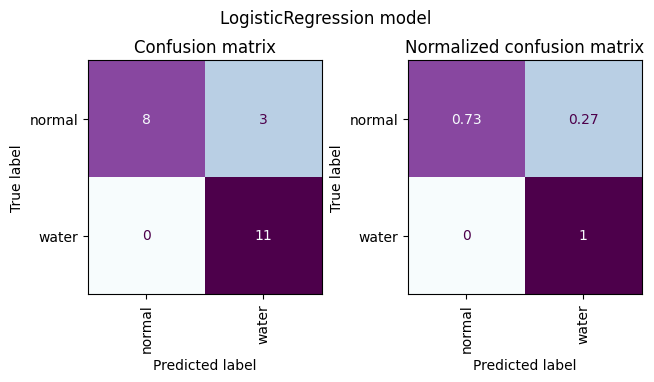

In [72]:
param_distributions = {
    "C": np.absolute(np.random.normal(loc=1.0, scale=1.0, size=100)),
}
logistic_regression = random_searcher(
    LogisticRegression,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test
)

In [73]:
print_searcher_info(logistic_regression)

============================== LogisticRegression ==============================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 3, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 10,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 10,
 'best estimator parameters': {'C': 0.7429901968980709,
                               'class_weight': None,
                               'dual': False,
                               'fit_intercept': True,
                               'intercept_scaling': 1,
                               'l1_ratio': None,
                               'max_iter': 100,
                               'multi_class': 'auto',
                               'n_jobs

## Support Vector Machines

Fitting 5 folds for each of 10 candidates, totalling 50 fits


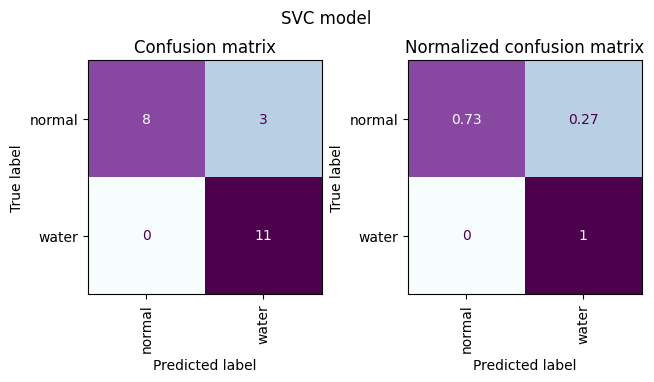

In [74]:
param_distributions = {
    "C": np.absolute(np.random.normal(loc=1.0, scale=1.0, size=10)),
    "gamma": ["scale", "auto"] + np.absolute(np.random.normal(size=5)).tolist(),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": np.arange(1, 6),
    "random_state": [RANDOM_STATE],
}
support_vector_machine = random_searcher(
    SVC,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test
)

In [75]:
print_searcher_info(support_vector_machine)

===================================== SVC ======================================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 3, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 10,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 10,
 'best estimator parameters': {'C': 1.3731313892884272,
                               'break_ties': False,
                               'cache_size': 200,
                               'class_weight': None,
                               'coef0': 0.0,
                               'decision_function_shape': 'ovr',
                               'degree': 3,
                               'gamma': 0.4813674178527704,
                            

## Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


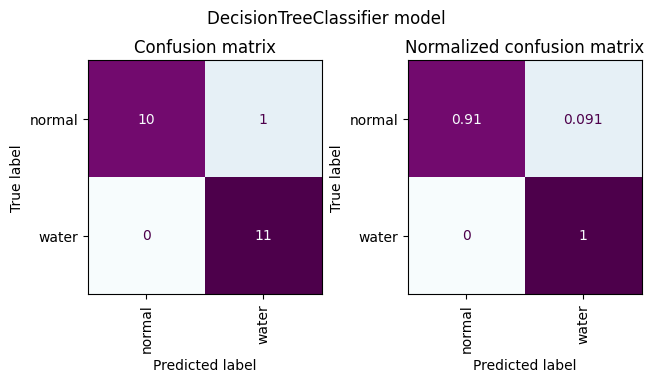

In [76]:
param_distributions = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(1, 20),
    "max_leaf_nodes": np.arange(20, 70),
    "min_samples_leaf": np.arange(1, 4),
    "random_state": [RANDOM_STATE],
}
decision_tree = random_searcher(
    DecisionTreeClassifier,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test
)

In [77]:
print_searcher_info(decision_tree)

============================ DecisionTreeClassifier ============================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 3, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 10,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 10,
 'best estimator parameters': {'ccp_alpha': 0.0,
                               'class_weight': None,
                               'criterion': 'gini',
                               'max_depth': 5,
                               'max_features': None,
                               'max_leaf_nodes': 28,
                               'min_impurity_decrease': 0.0,
                               'min_samples_leaf': 3,
                               

## Random Forest

Fitting 5 folds for each of 5 candidates, totalling 25 fits


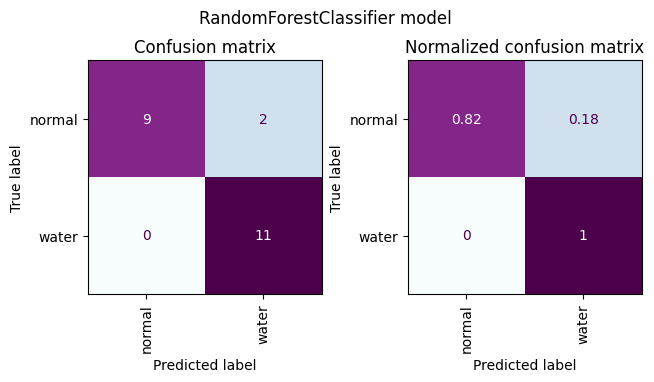

In [78]:
param_distributions = {
    "n_estimators": np.arange(100, 1500, 100),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(1, 20),
    "min_samples_leaf": np.arange(1, 4),
    "random_state": [RANDOM_STATE],
    "n_jobs": [-1], # Use all cores
}
random_forest = random_searcher(
    RandomForestClassifier,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test,
    n_iter=5
)

In [79]:
print_searcher_info(random_forest)

============================ RandomForestClassifier ============================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 3, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 5,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 5,
 'best estimator parameters': {'bootstrap': True,
                               'ccp_alpha': 0.0,
                               'class_weight': None,
                               'criterion': 'log_loss',
                               'max_depth': 6,
                               'max_features': 'sqrt',
                               'max_leaf_nodes': None,
                               'max_samples': None,
                               'min_im

# Conclusion

Lets summarize all of the accuracy scores:

In [80]:
models = [logistic_regression, support_vector_machine, decision_tree, random_forest]

for model in models:
    print(f"{model['model']} accuracy: {model['test']['accuracy']:.3f}")

LogisticRegression accuracy: 0.864
SVC accuracy: 0.864
DecisionTreeClassifier accuracy: 0.955
RandomForestClassifier accuracy: 0.909


The results above are favorable for the tree based models (decision tree and random forest), with scores ranging from around 90% to 95%. However, logistic regression and support vector machine models do not sit at bad position too, with scores around 86% or below. Since the decision tree model is way faster than the random forest and both have the same accuracy, the prefered model for this classification task is the decision tree.